In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from extra_keras_metrics import average_precision_at_k


import tensorflow as tf

# Set some parameters
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 25
TRAIN_PATH = 'GeneratedData/train/'
TEST_PATH = 'GeneratedData/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Get train and test ids
train_ids = np.loadtxt(TRAIN_PATH + 'Directory.txt').astype(int)
test_ids = np.loadtxt(TEST_PATH + 'Directory.txt').astype(int)

In [3]:
print("train ids(%i):" % (len(train_ids)), train_ids, "\n")
print("test ids(%i):" % (len(test_ids)), test_ids)

train ids(1000): [231734753 231734784 231734812 231734849 231734892 231734933 231734972
 231735007 231735043 231735083 231735114 231735165 231735222 231735257
 231735285 231735320 231735370 231735392 231735445 231735498 231735537
 231735578 231735614 231735660 231735692 231735735 231735771 231735797
 231735840 231735871 231735891 231735944 231735981 231736008 231736063
 231736109 231736156 231736198 231736252 231736286 231736329 231736362
 231736394 231736446 231736475 231736513 231736541 231736573 231736597
 231736647 231736683 231736711 231736748 231736793 231736826 231736870
 231736895 231736938 231736987 231737024 231737054 231737086 231737121
 231737170 231737208 231737248 231737280 231737321 231737366 231737400
 231737434 231737461 231737514 231737552 231737591 231737635 231737681
 231737722 231737782 231737813 231737860 231737887 231737939 231737982
 231738021 231738068 231738092 231738148 231738169 231738205 231738244
 231738282 231738321 231738363 231738387 231738413 231738440

# Data processing

In [4]:
X_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# Get train images and masks
print('Getting train images and masks ... ')
sys.stdout.flush()
for n, id in tqdm(enumerate(train_ids), total=len(train_ids)):
    img_path = TRAIN_PATH + 'ImageMap-' + str(id) + '.dat'
    img_zxy = np.fromfile(img_path, dtype='uint8')
    img_zxy.shape = (IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT)
    # convert from 25x64x64 to 64x64x25
    img_xyz = np.zeros((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    for i in range(IMG_CHANNELS):
        img_xyz[:,:,i] = img_zxy[i,:,:]
    X_train[n] = img_xyz
    
    mask_path = TRAIN_PATH + 'LabelMap-' + str(id) + '.dat'
    mask = np.fromfile(mask_path, dtype=np.bool)
    mask.shape = (IMG_WIDTH, IMG_HEIGHT, 1)
    Y_train[n] = mask

# Get test images and masks
print('Getting test images and masks ... ')
sys.stdout.flush()
X_test = np.zeros((len(test_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, id in tqdm(enumerate(test_ids), total=len(test_ids)):
    img_path = TEST_PATH + 'ImageMap-' + str(id) + '.dat'
    img_zxy = np.fromfile(img_path, dtype='uint8')
    img_zxy.shape = (IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT)
    # convert from 25x64x64 to 64x64x25
    img_xyz = np.zeros((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    for i in range(IMG_CHANNELS):
        img_xyz[:,:,i] = img_zxy[i,:,:]
    X_test[n] = img_xyz
    
    mask_path = TEST_PATH + 'LabelMap-' + str(id) + '.dat'
    mask = np.fromfile(mask_path, dtype=np.bool)
    mask.shape = (IMG_WIDTH, IMG_HEIGHT, 1)
    Y_test[n] = mask

print("Done!")

Getting train images and masks ... 


100%|██████████| 1000/1000 [00:00<00:00, 1156.94it/s]

Getting test images and masks ... 



100%|██████████| 100/100 [00:00<00:00, 1101.46it/s]

Done!


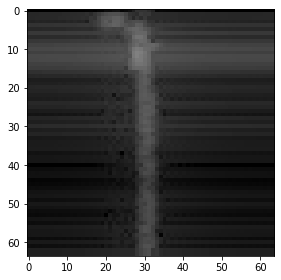

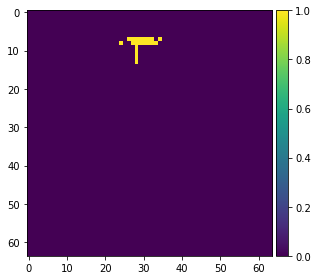

In [5]:
# Check if training data looks okay
img_idx = random.randint(0, len(train_ids)-1)
color_idx = random.randint(0, IMG_CHANNELS-1)
imshow(X_train[img_idx,:,:,color_idx])
plt.show()
imshow(np.squeeze(Y_train[img_idx]))
plt.show()

# Create model

Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [6]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

# Encoder layers
c0 = Conv2D(4, (3, 3), activation='relu', padding='same') (s)
c0 = Conv2D(4, (3, 3), activation='relu', padding='same') (c0)
p0 = MaxPooling2D((2, 2)) (c0)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (p0)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
# --------------------------------------------------------------

# Decoder layers
u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c4)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

u10 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c0], axis=3)
c10 = Conv2D(4, (3, 3), activation='relu', padding='same') (u10)
c10 = Conv2D(4, (3, 3), activation='relu', padding='same') (c10)
# --------------------------------------------------------------

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c10)

model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[average_precision_at_k(1)])
model.summary()

W0805 14:21:44.440690 140505076422464 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 14:21:44.463220 140505076422464 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 14:21:44.473734 140505076422464 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 14:21:44.512783 140505076422464 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 25)   0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64, 64, 25)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 4)    904         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 4)    148         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin


# Training

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway).

In [7]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-SonarNet-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                   callbacks=[earlystopper, checkpointer])

Train on 900 samples, validate on 100 samples
Epoch 1/30
900/900 [==============================] - 12s 13ms/step - loss: 0.1507 - average_precision_at_k1: 0.9959 - val_loss: 0.0713 - val_average_precision_at_k1: 0.9959

Epoch 00001: val_loss improved from inf to 0.07134, saving model to model-SonarNet-1.h5
Epoch 2/30
900/900 [==============================] - 10s 11ms/step - loss: 0.0656 - average_precision_at_k1: 0.9959 - val_loss: 0.0713 - val_average_precision_at_k1: 0.9959

Epoch 00002: val_loss did not improve from 0.07134
Epoch 3/30
900/900 [==============================] - 10s 11ms/step - loss: 0.0656 - average_precision_at_k1: 0.9959 - val_loss: 0.0713 - val_average_precision_at_k1: 0.9959

Epoch 00003: val_loss did not improve from 0.07134
Epoch 4/30
900/900 [==============================] - 10s 11ms/step - loss: 0.0656 - average_precision_at_k1: 0.9959 - val_loss: 0.0713 - val_average_precision_at_k1: 0.9959

Epoch 00004: val_loss did not improve from 0.07134
Epoch 5/30
90

# Detection

In [13]:
# Predict on train, val and test
model = load_model('model-SonarNet-1.h5', custom_objects={})

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

ValueError: Unknown metric function:average_precision_at_k1

In [ ]:
# Perform a sanity check on some random training samples
img_idx = random.randint(0, len(preds_train_t))
color_idx = random.randint(0, IMG_CHANNELS)

In [ ]:
imshow(X_train[img_idx,:,:,color_idx])
plt.title("Image (1 color plane)")
plt.show()
plt.title("True mask")
imshow(np.squeeze(Y_train[img_idx]))
plt.show()
plt.title("Predicted mask")
imshow(np.squeeze(preds_train_t[img_idx]))
plt.show()

# Evaluation

In [ ]:
# Compute VOC-Style mAP(mean average precision) @ IoU=0.5
y_true = Y_train[img_idx].astype(np.int64)
y_true = tf.identity(y_true)

y_pred = preds_train_t[img_idx].astype(np.float32)
y_pred = tf.identity(y_pred)

_, m_ap = tf.metrics.average_precision_at_k(y_true, y_pred, 1)

sess = tf.Session()
sess.run(tf.local_variables_initializer())

tf_map = sess.run(m_ap)

print(tf_map)

---

# Test code

In [ ]:
# show all images
for img in X_train:
    imshow(img[:,:,15])
    plt.show()

In [ ]:
# show all masks
for mask in Y_train:
    imshow(np.squeeze(mask))
    plt.show()